## import packages

In [1]:
import json
import re
import pandas as pd
import nltk
import sklearn
from nltk.stem import WordNetLemmatizer
import numpy as np
from nltk.tokenize import word_tokenize
import string
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn import linear_model
import collections
from gensim.models import Word2Vec
from gensim.models import word2vec
import multiprocessing
import time
import inflect
from textblob import TextBlob
import keras.preprocessing.text as T
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer #该类会将文本中的词语转换为词频矩阵，矩阵元素a[i][j] 表示j词在i类文本下的词频
from sklearn.feature_extraction.text import TfidfTransformer

## define stopwords
sr = stopwords.words('english')
p = inflect.engine()
wnl = WordNetLemmatizer() 
table = str.maketrans('', '', string.punctuation)

Using TensorFlow backend.


## define function "read_json" and "write_json"

In [2]:
def read_json(path):
    with open(path, 'r',encoding='utf-8') as f:
        iter_f = iter(f)
        line = f.readline()
        text = []
        for line in iter_f: 
            d = json.loads(line)
            print(d)
            text.append(d)
        f.close()
    return(text)
    
def write_json(path, data):
    with open(path, 'w', encoding="utf-8") as f:
        json.dump(data, f, indent=2)
    return 0

## read "example.json"

In [3]:
with open('example.json', 'r',encoding='utf-8') as f:
    data = f.read()
    json_data = json.loads(data)
f.close()

In [4]:
type(json_data)

list

In [5]:
# have a look at data
json_data[1]

{'review_id': '8NBE5q5UWLQUqWyM7GpQ2g',
 'user_id': 'StZTVDuFzahNvjl5qu6l7Q',
 'business_id': 'nsNONDHbV7Vudqh21uicqw',
 'stars': 2.0,
 'useful': 1,
 'funny': 1,
 'cool': 1,
 'text': 'Seems old and tired!   I ate here frequently about 20 years ago and returned for happy hour this year.  This used to be a good place many years ago, but too many great restaurants have opened in recent years to eat here.  Strange rules about what you can eat in the bar area.  Food just meh.',
 'date': '2018-05-08 17:18:20'}

In [6]:
# length of data
len(json_data)

543

## convert text to words

In [3]:
# define function to change text to words
def clean_review(text):
    #Change n't into not
    x = re.sub(r'n\'t',' not',text)
    #Change not word into not_word
    x = re.sub(r'not ','not_',x)
    #Split into words
    x = word_tokenize(x)
    #Remove punctuation
    x = [w.translate(table) if not re.match(r'not_.*', w) else w for w in x]
    #Change numbers into words
    x = [p.number_to_words(w) if w.isdigit() else w  for w in x ]
    #Remove non alphabetic
    x = [w for w in x if w.isalpha() or re.match(r'not_.*',w)]
    #Convert to lower case
    x = [w.lower() for w in x]
    #Remove stop words
    x = [w for w in x if not w in sr]
    ## lemmatization
    x = [wnl.lemmatize(w) for w in x]
    return x

In [8]:
# prepare words set for different level of stars
stars = []
allwords = []
onestarwords = []
twostarwords = []
threestarwords = []
fourstarwords = []
fivestarwords = []
clean_text = [[1]]*len(json_data)
for i in range(len(json_data)):
    stars.append(json_data[i]['stars'])
    clean_text[i]=clean_review(json_data[i]['text'])
    allwords= allwords +clean_text[i]
    if stars[i] == 1.0:
        onestarwords= onestarwords +clean_text[i]
    elif stars[i] == 2.0:
        twostarwords= twostarwords +clean_text[i]
    elif stars[i] == 3.0:
        threestarwords= threestarwords +clean_text[i]
    elif stars[i] == 4.0:
        fourstarwords= fourstarwords +clean_text[i]
    elif stars[i] == 5.0:
        fivestarwords= fivestarwords +clean_text[i]

# build a dataframe for stars and words
review_clean = pd.DataFrame(stars)
review_clean.columns=["stars"]
review_clean["words"]=clean_text
# review_clean_text = pd.DataFrame(clean_text)
# review_clean_text
# review_clean = pd.concat([review_stars, review_clean_text], axis=1)
# review_clean.columns = ["stars","clean_text"]
# review_clean.head()
len(review_clean)
len(stars)
len(clean_text)

543

In [9]:
# have a look at new dataframe
review_clean.head()

stars                                              words
0    1.0  [excited, happy, hour, heard, great, thing, fo...
1    2.0  [seems, old, tired, ate, frequently, twenty, y...
2    1.0  [poor, service, sit, ask, wife, continuesly, w...
3    1.0  [yesterday, took, husband, eat, birthday, food...
4    1.0  [second, last, time, sadly, wait, food, everyo...

In [4]:
## example    
    x = "Seems old and tired! And I wouldn't come again 3. not great."
    p = inflect.engine()
    x = re.sub(r'n\'t',' not',x)
    #Change not adj into not_adj
    x = re.sub(r'not ','not_',x)
    #Split into words
    x = word_tokenize(x)
    #Remove punctuation
    x = [w.translate(table) if not re.match(r'not_.*', w) else w for w in x]
#     print(x)
    #Change numbers into words
    x = [p.number_to_words(w) if w.isdigit() else w  for w in x ]
    print(x)
    #Remove not alphabetic
    x = [w for w in x if w.isalpha() or re.match(r'not_.*',w)]
    print(x)
    #Convert to lower case
    x = [w.lower() for w in x]
#     print(x)
    #Remove stop words
    x = [w for w in x if not w in sr]
#     print(x)
    ## lemmatization
    x = [wnl.lemmatize(w) for w in x]
    print(x)

['Seems', 'old', 'and', 'tired', '', 'And', 'I', 'would', 'not_come', 'again', 'three', 'not_great', '']
['Seems', 'old', 'and', 'tired', 'And', 'I', 'would', 'not_come', 'again', 'three', 'not_great']
['seems', 'old', 'tired', 'would', 'not_come', 'three', 'not_great']


## delete some useless but frequent words

In [23]:
delete_words=['food','place','good','seafood','great', 'restaurant','time','like','one','u','back',
              'would','go','happy','get','could','experience','went','make','made','thing']

## plot wordcloud for 100 most common words among all the reviews for a classical seafood restaurant "Salt Celler"

In [28]:
# count word frequency and find 100 most common words
frequency = collections.Counter(allwords)
for word in delete_words:
    frequency.pop(word)
common = frequency.most_common(100)
frequency = dict(frequency)
#len(frequency)
# common
# dict(common)

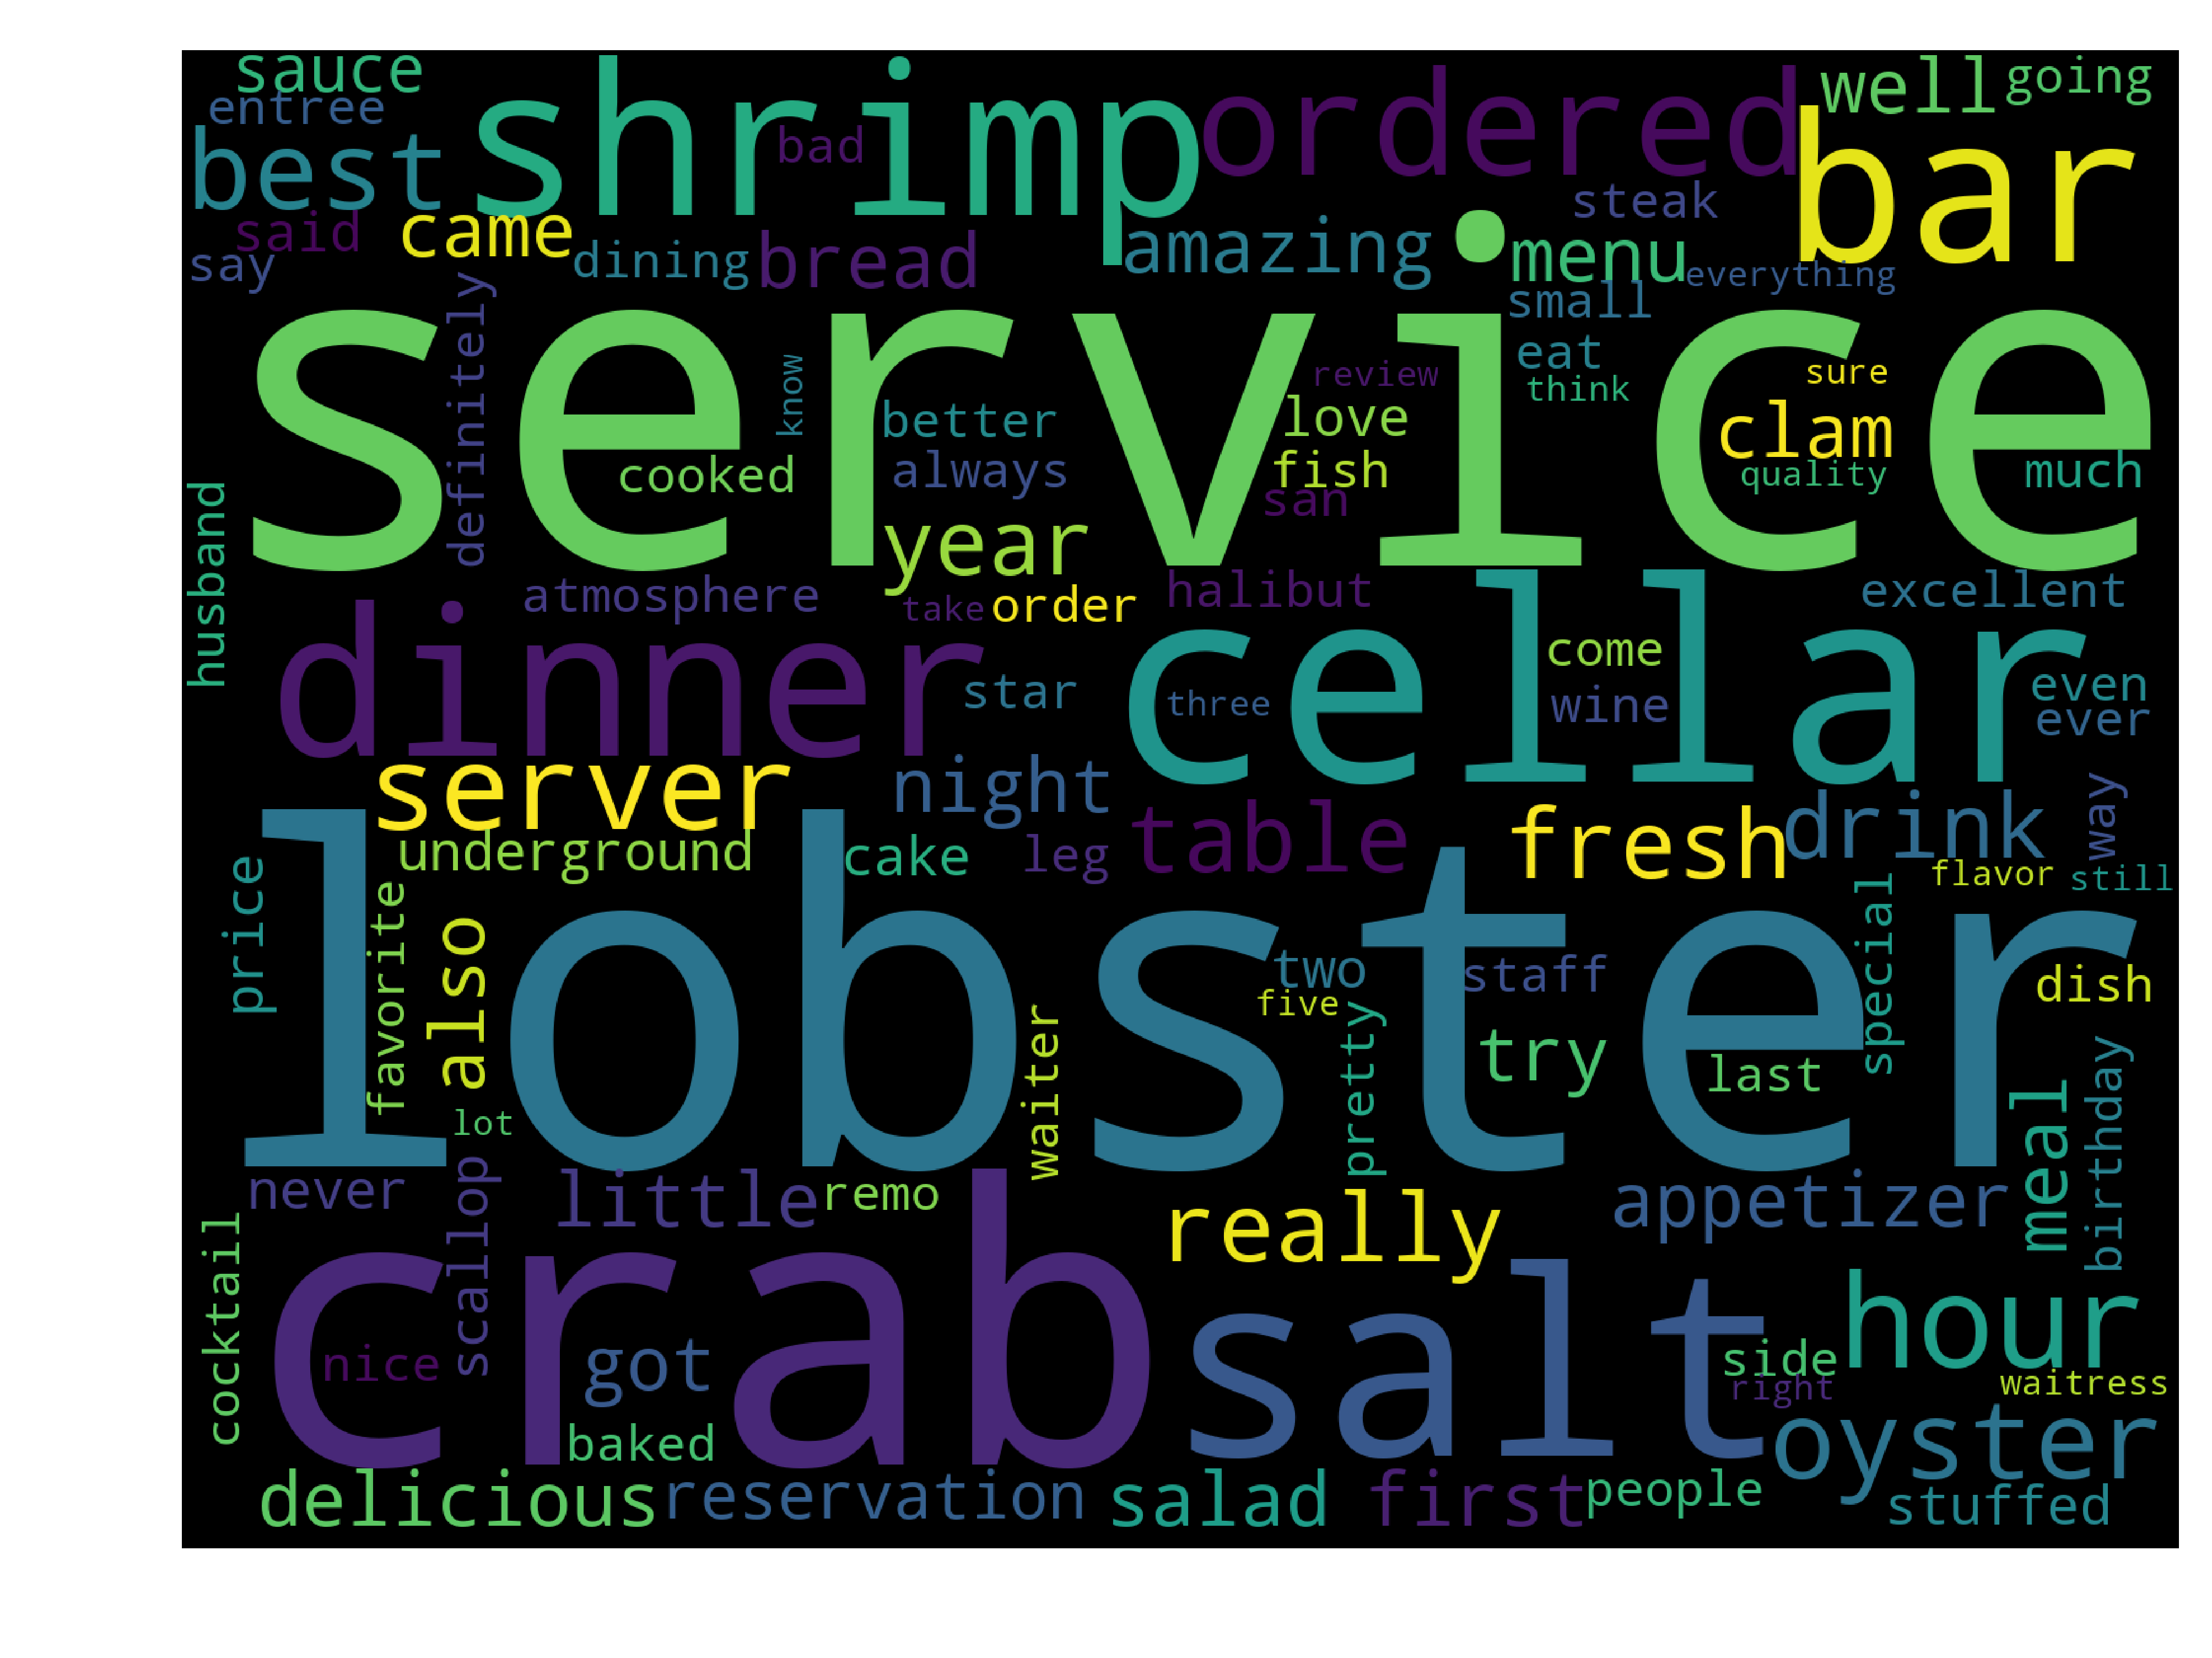

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color = 'Black',width=400,height=300,scale=4,max_font_size=100)
wc.generate_from_frequencies(dict(common))

plt.figure(figsize=(10,6), dpi=600)
plt.imshow(wc)
plt.axis("off")
plt.savefig('wordcloud_allwords.jpg')
plt.show()


## 100 most frequency wordcloud for 1 star restaurant

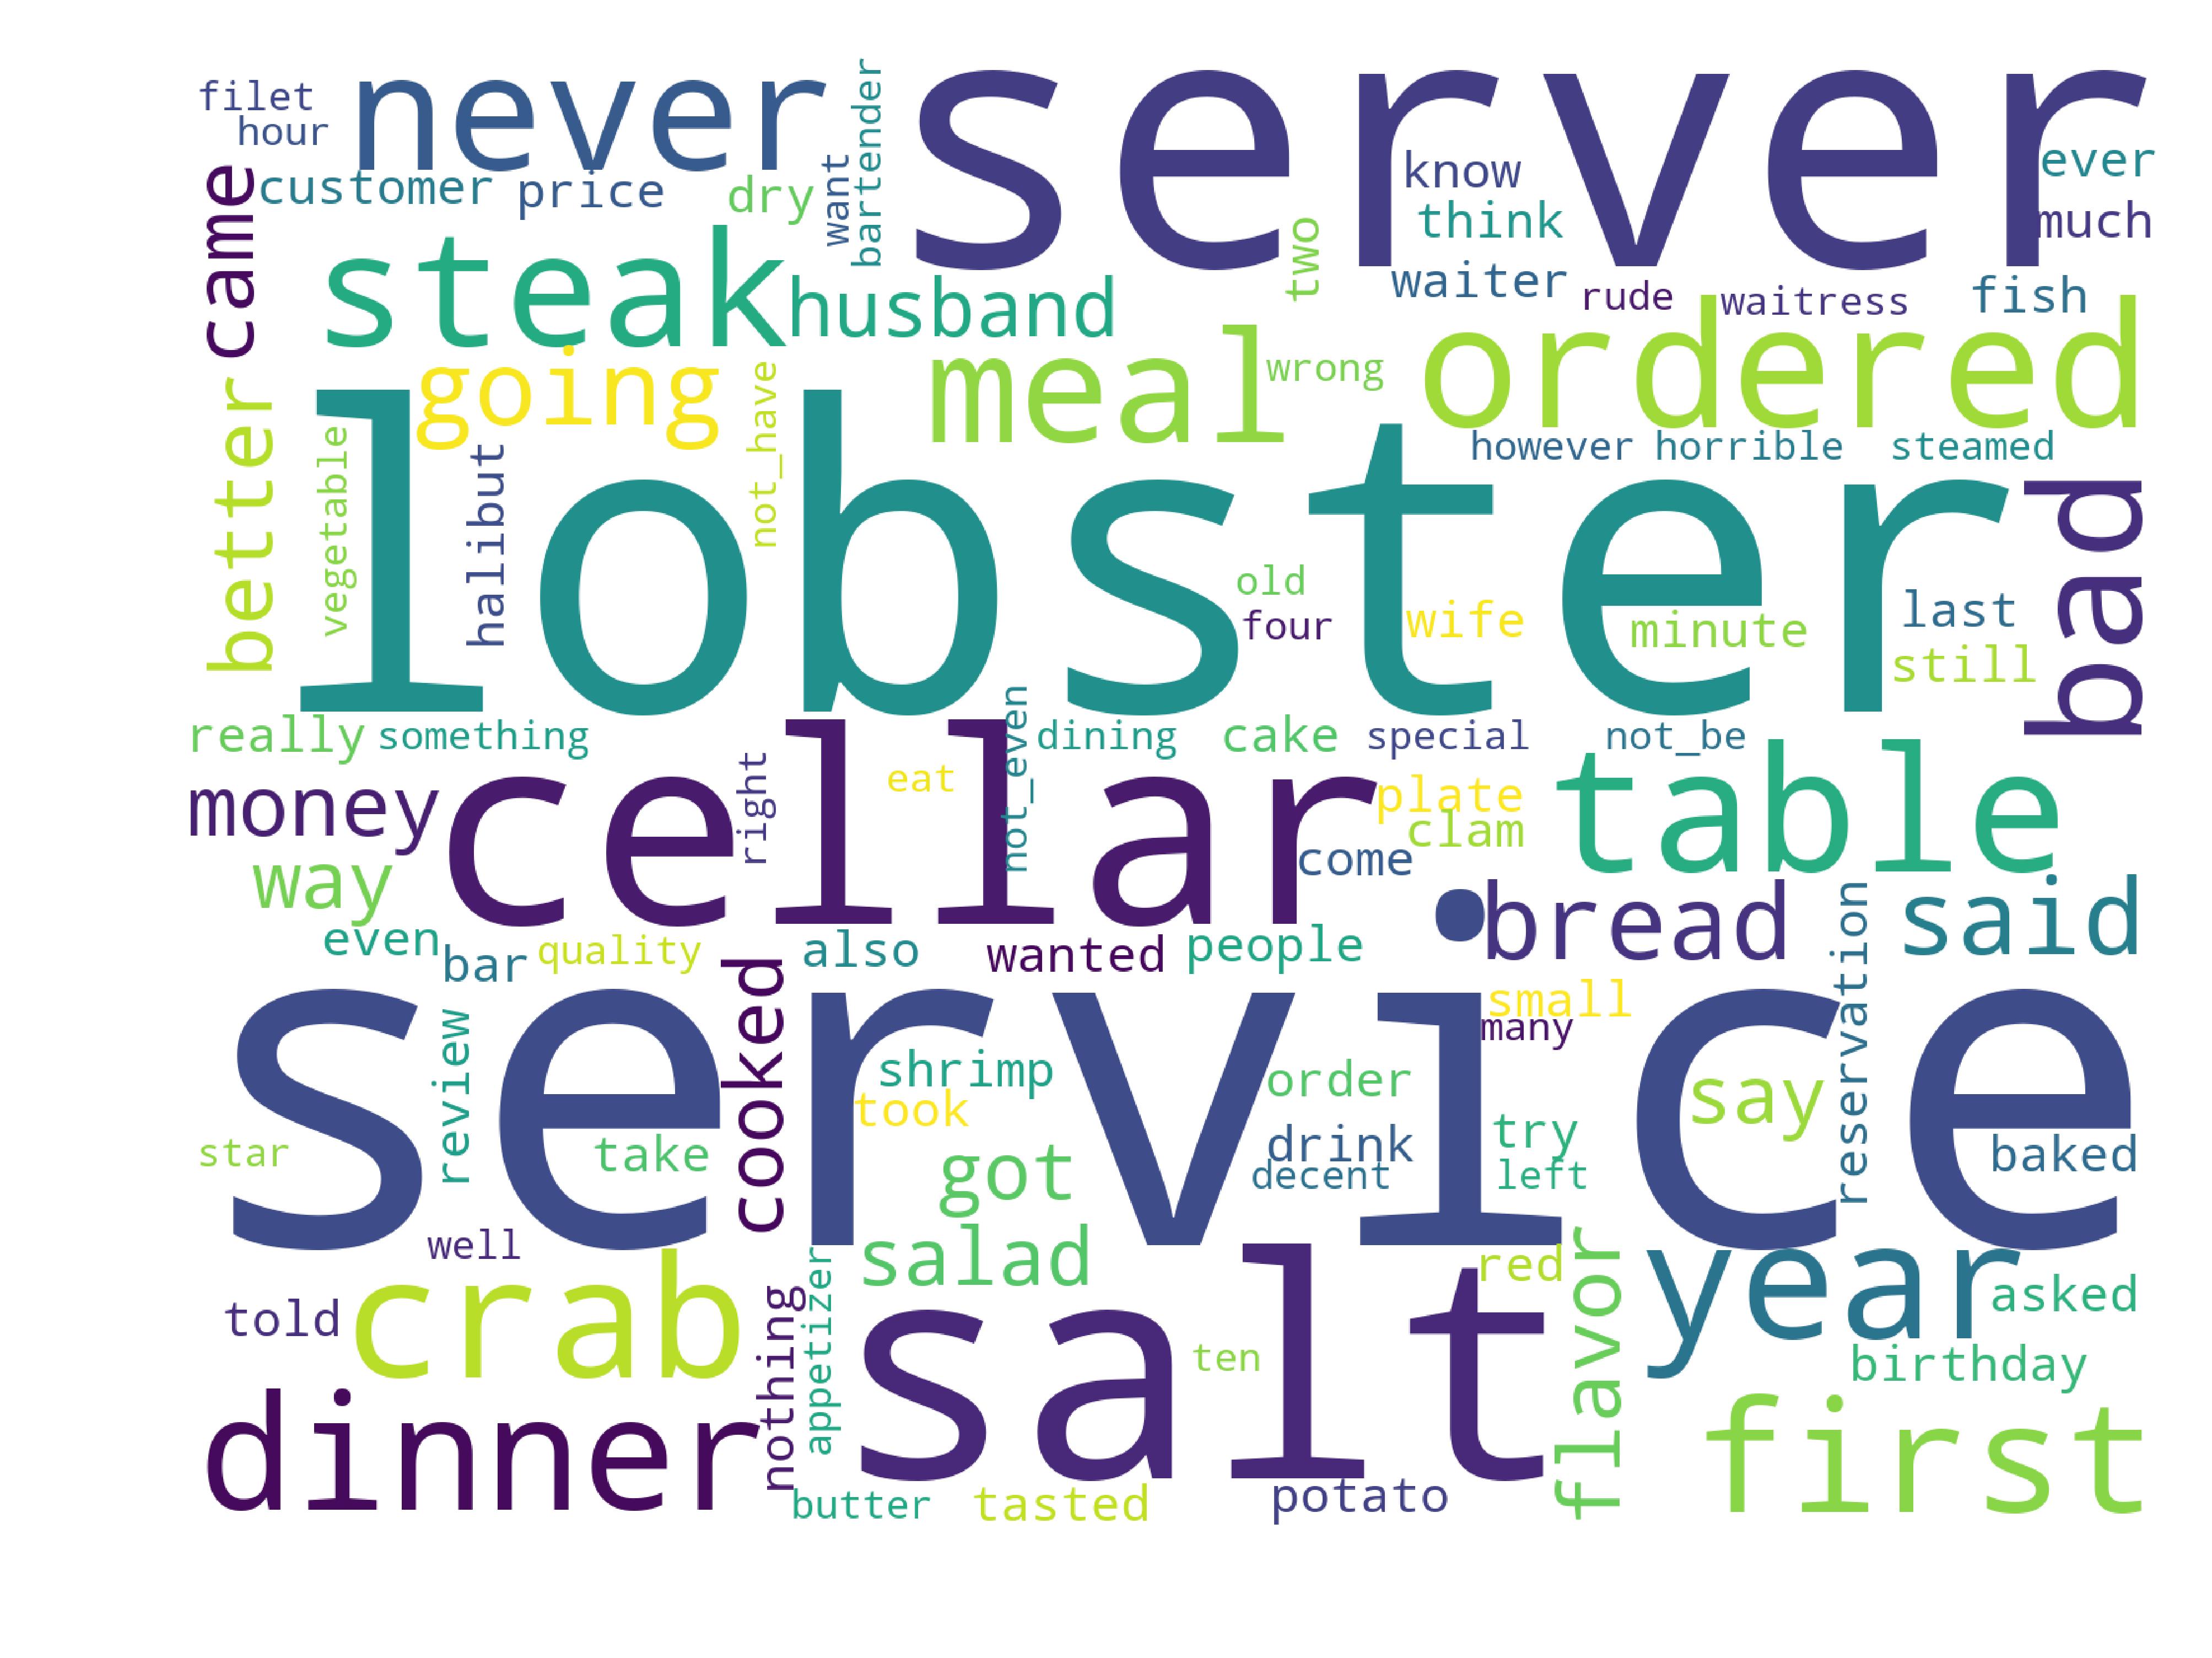

In [31]:
onestarfreq = collections.Counter(onestarwords)
for word in delete_words:
    onestarfreq.pop(word)
common1 = dict(onestarfreq.most_common(100))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color = 'White',width=400,height=300,scale=4,max_font_size=100)
wc.generate_from_frequencies(common1)

plt.figure(figsize=(10,6), dpi=600)
plt.imshow(wc)
plt.axis("off")
plt.savefig('wordcloud_onestarwords.jpg')
plt.show()

## 100 most frequency wordcloud for 2 star restaurant

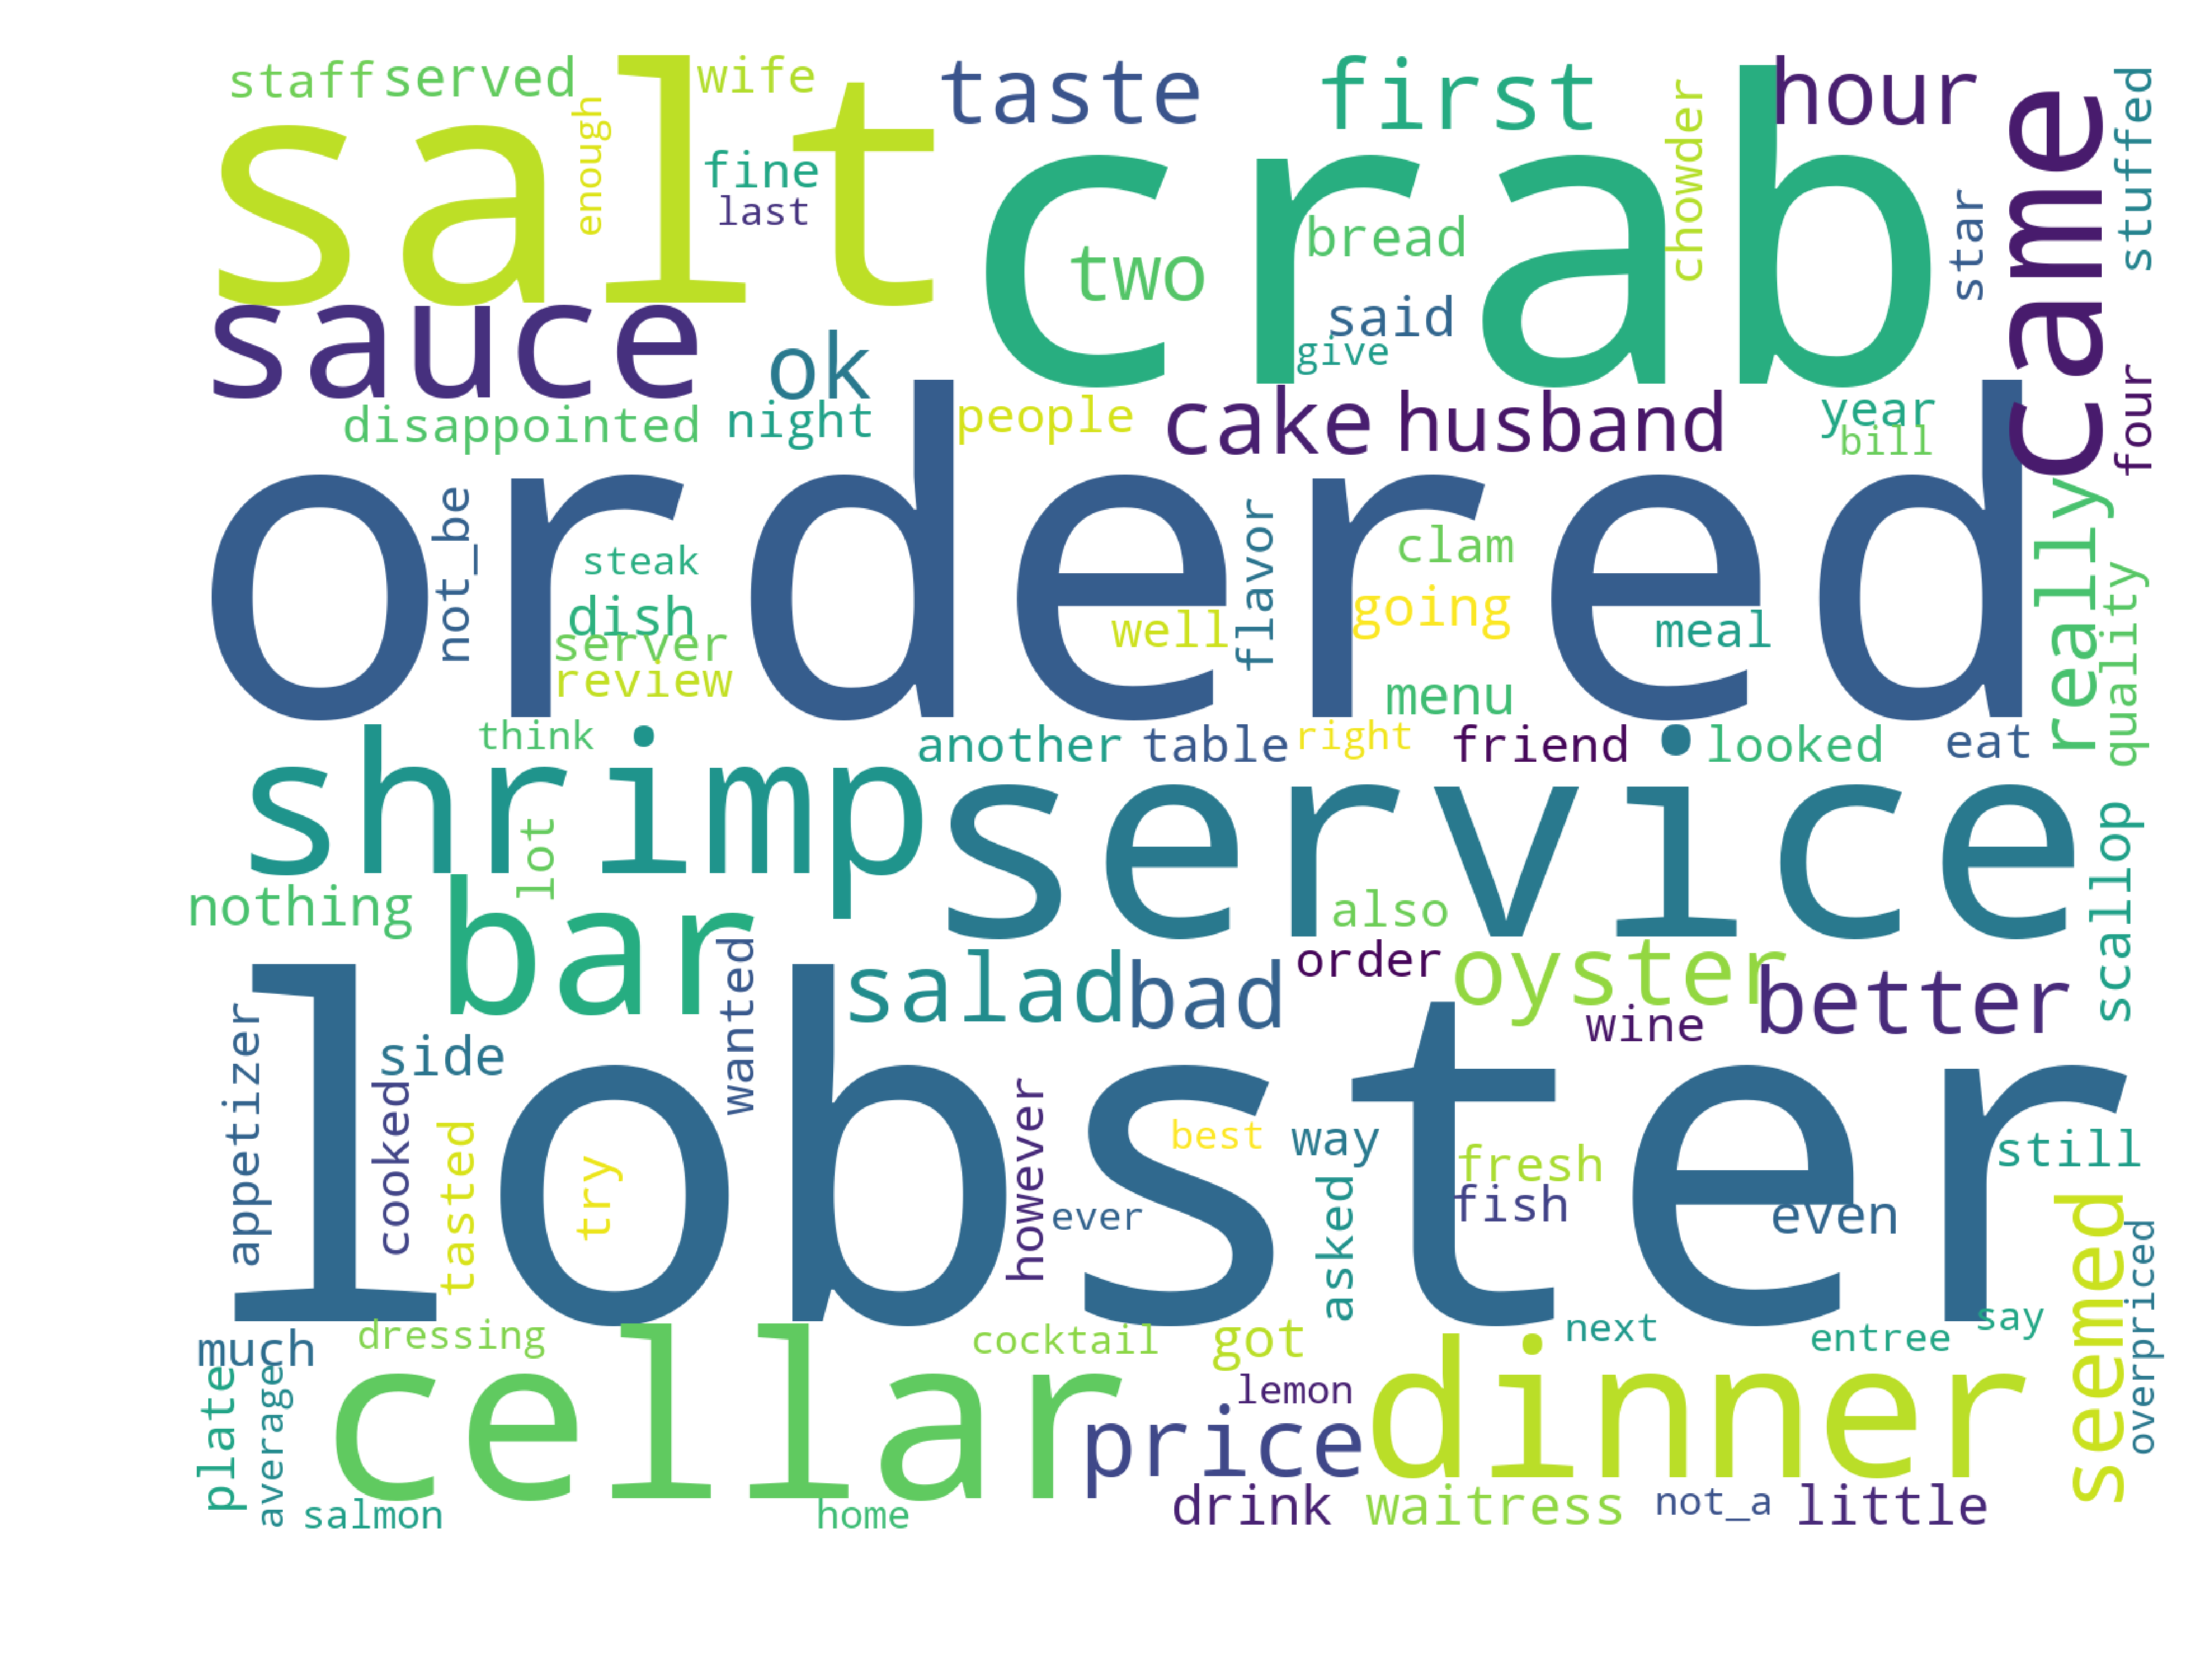

In [34]:
twostarfreq = collections.Counter(twostarwords)
for word in delete_words:
    twostarfreq.pop(word)
common2 = dict(twostarfreq.most_common(100))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color = 'White',width=400,height=300,scale=4,max_font_size=100)
wc.generate_from_frequencies(common2)

plt.figure(figsize=(10,6), dpi=600)
plt.imshow(wc)
plt.axis("off")
plt.savefig('wordcloud_twostarwords.jpg')
plt.show()

## 100 most frequency wordcloud for 3 star restaurant

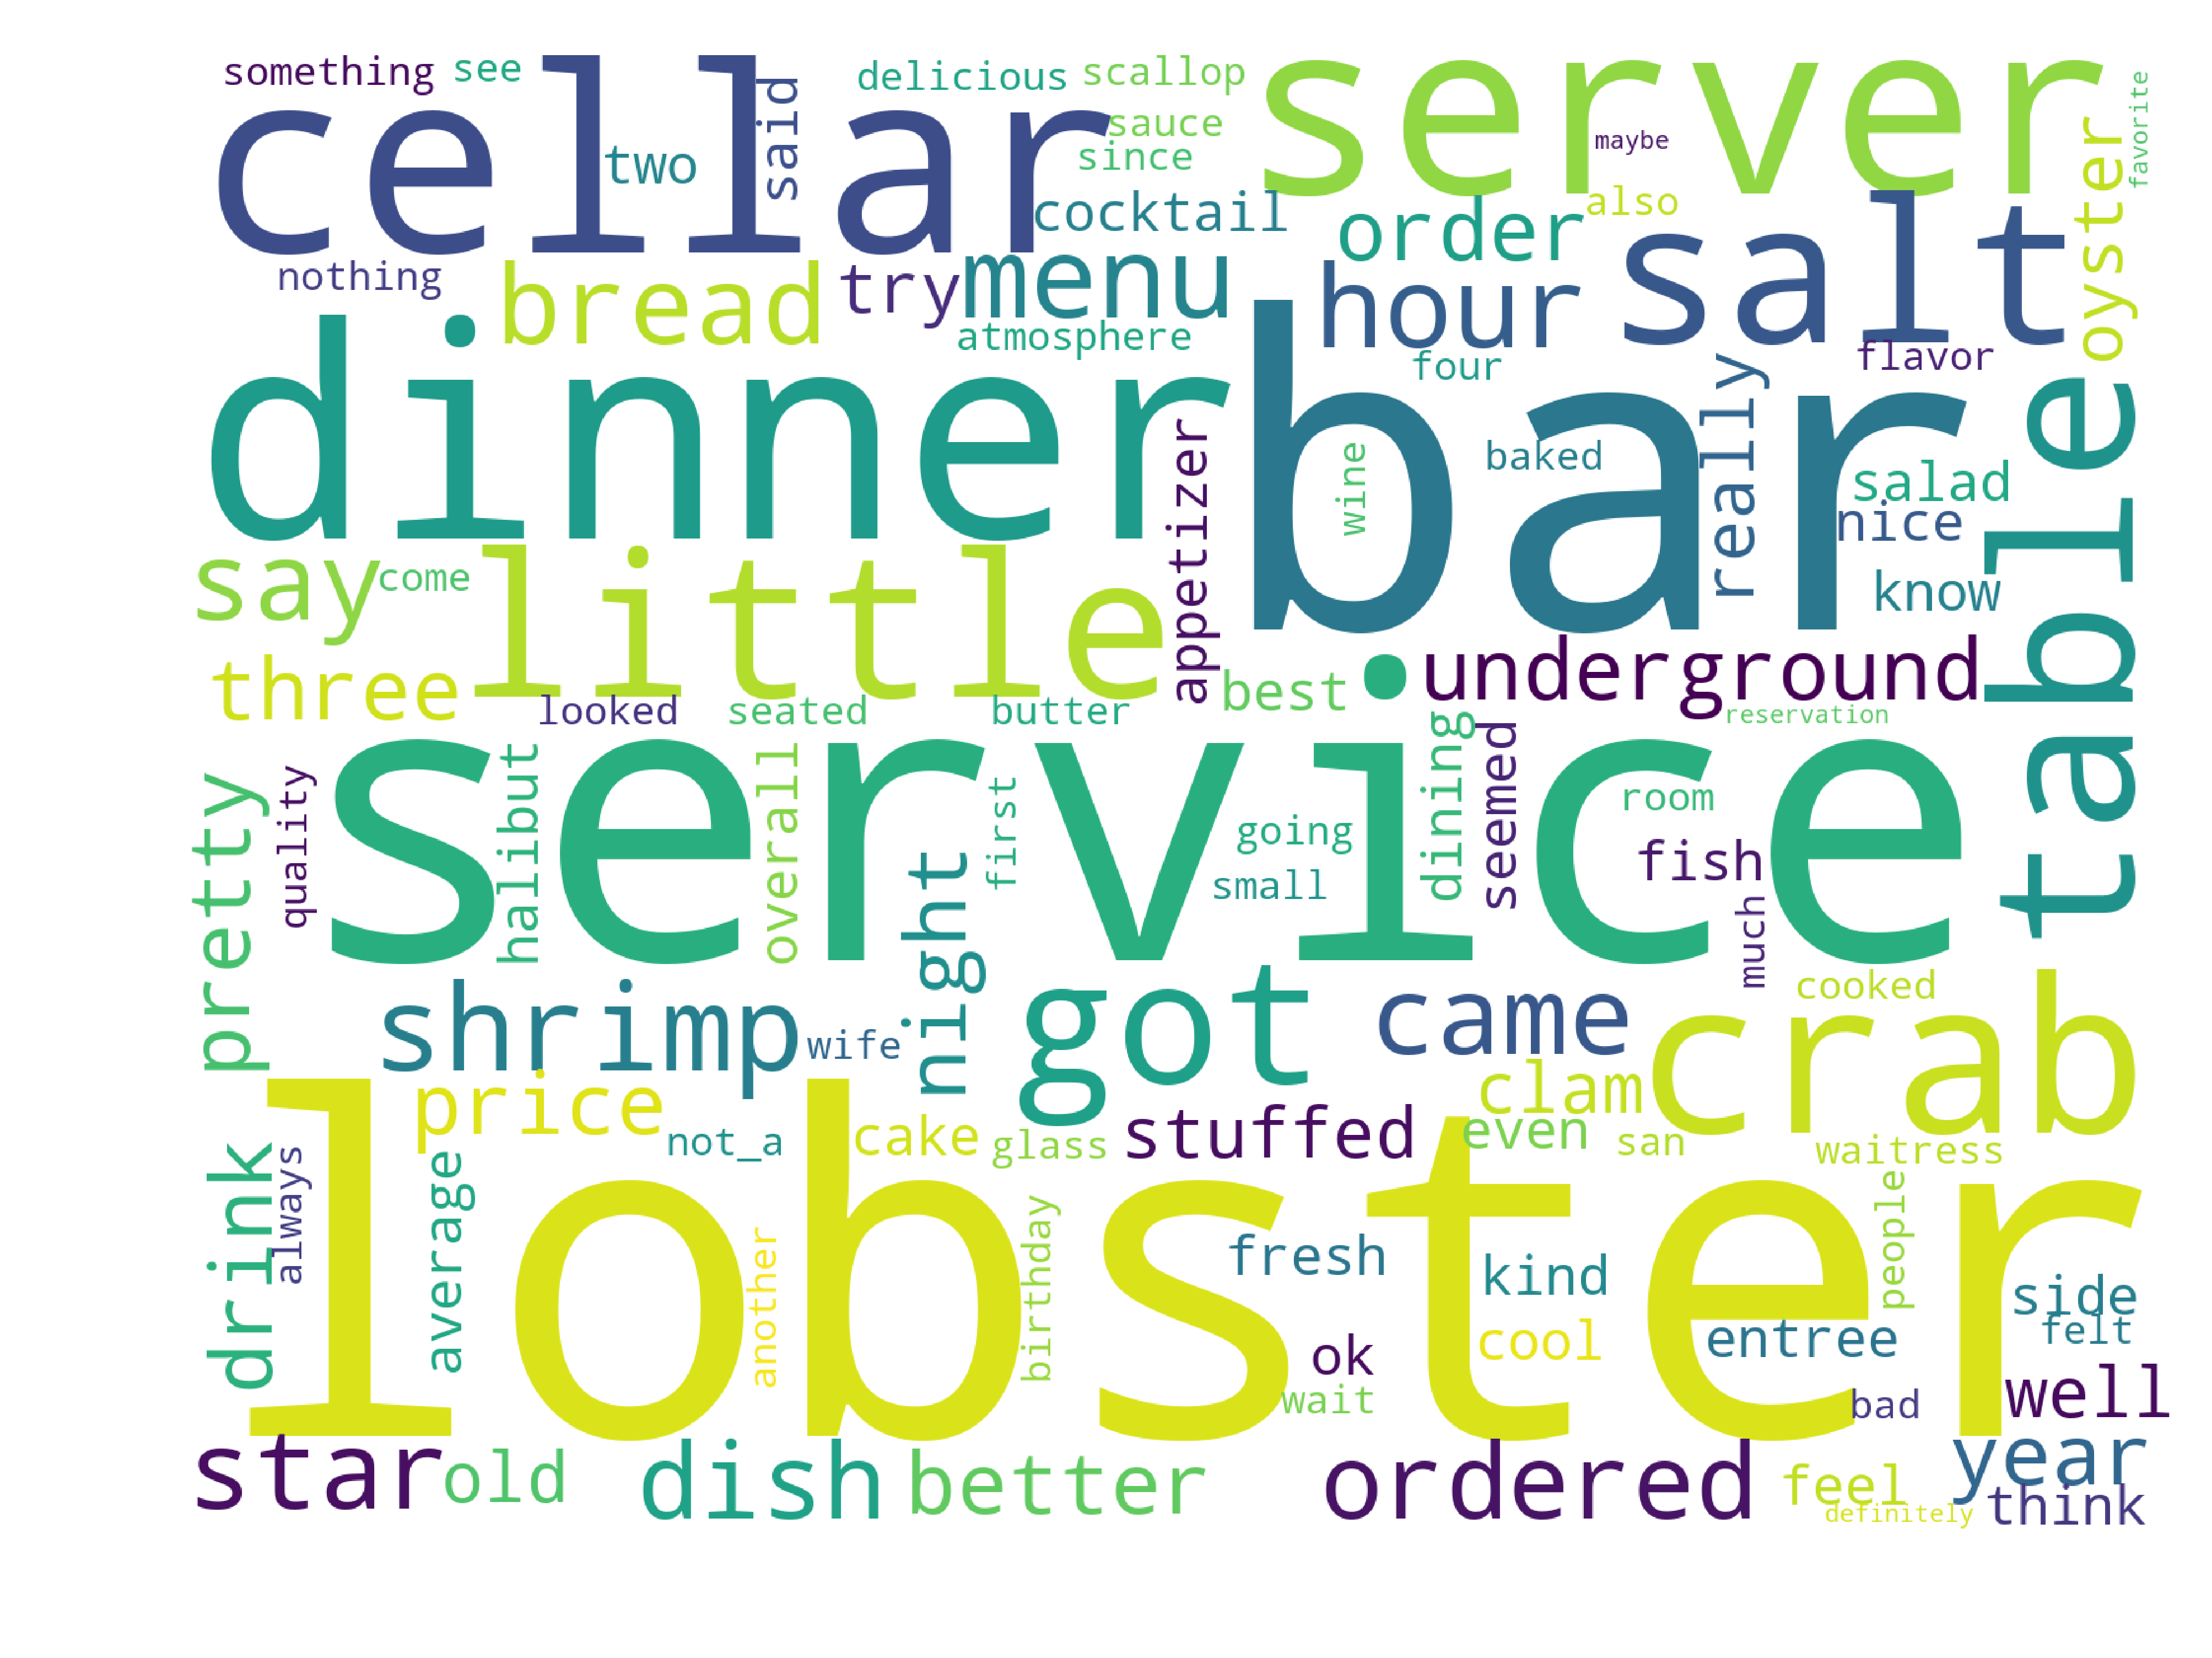

In [36]:
threestarfreq = collections.Counter(threestarwords)
for word in delete_words:
    threestarfreq.pop(word)
common3 = dict(threestarfreq.most_common(100))
# threestarwords
# threestarfreq
# common3

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color = 'White',width=400,height=300,scale=4,max_font_size=100)
wc.generate_from_frequencies(common3)

plt.figure(figsize=(10,6), dpi=600)
plt.imshow(wc)
plt.axis("off")
plt.savefig('wordcloud_threestarwords.jpg')
plt.show()

## 100 most frequency wordcloud for 4 star restaurant

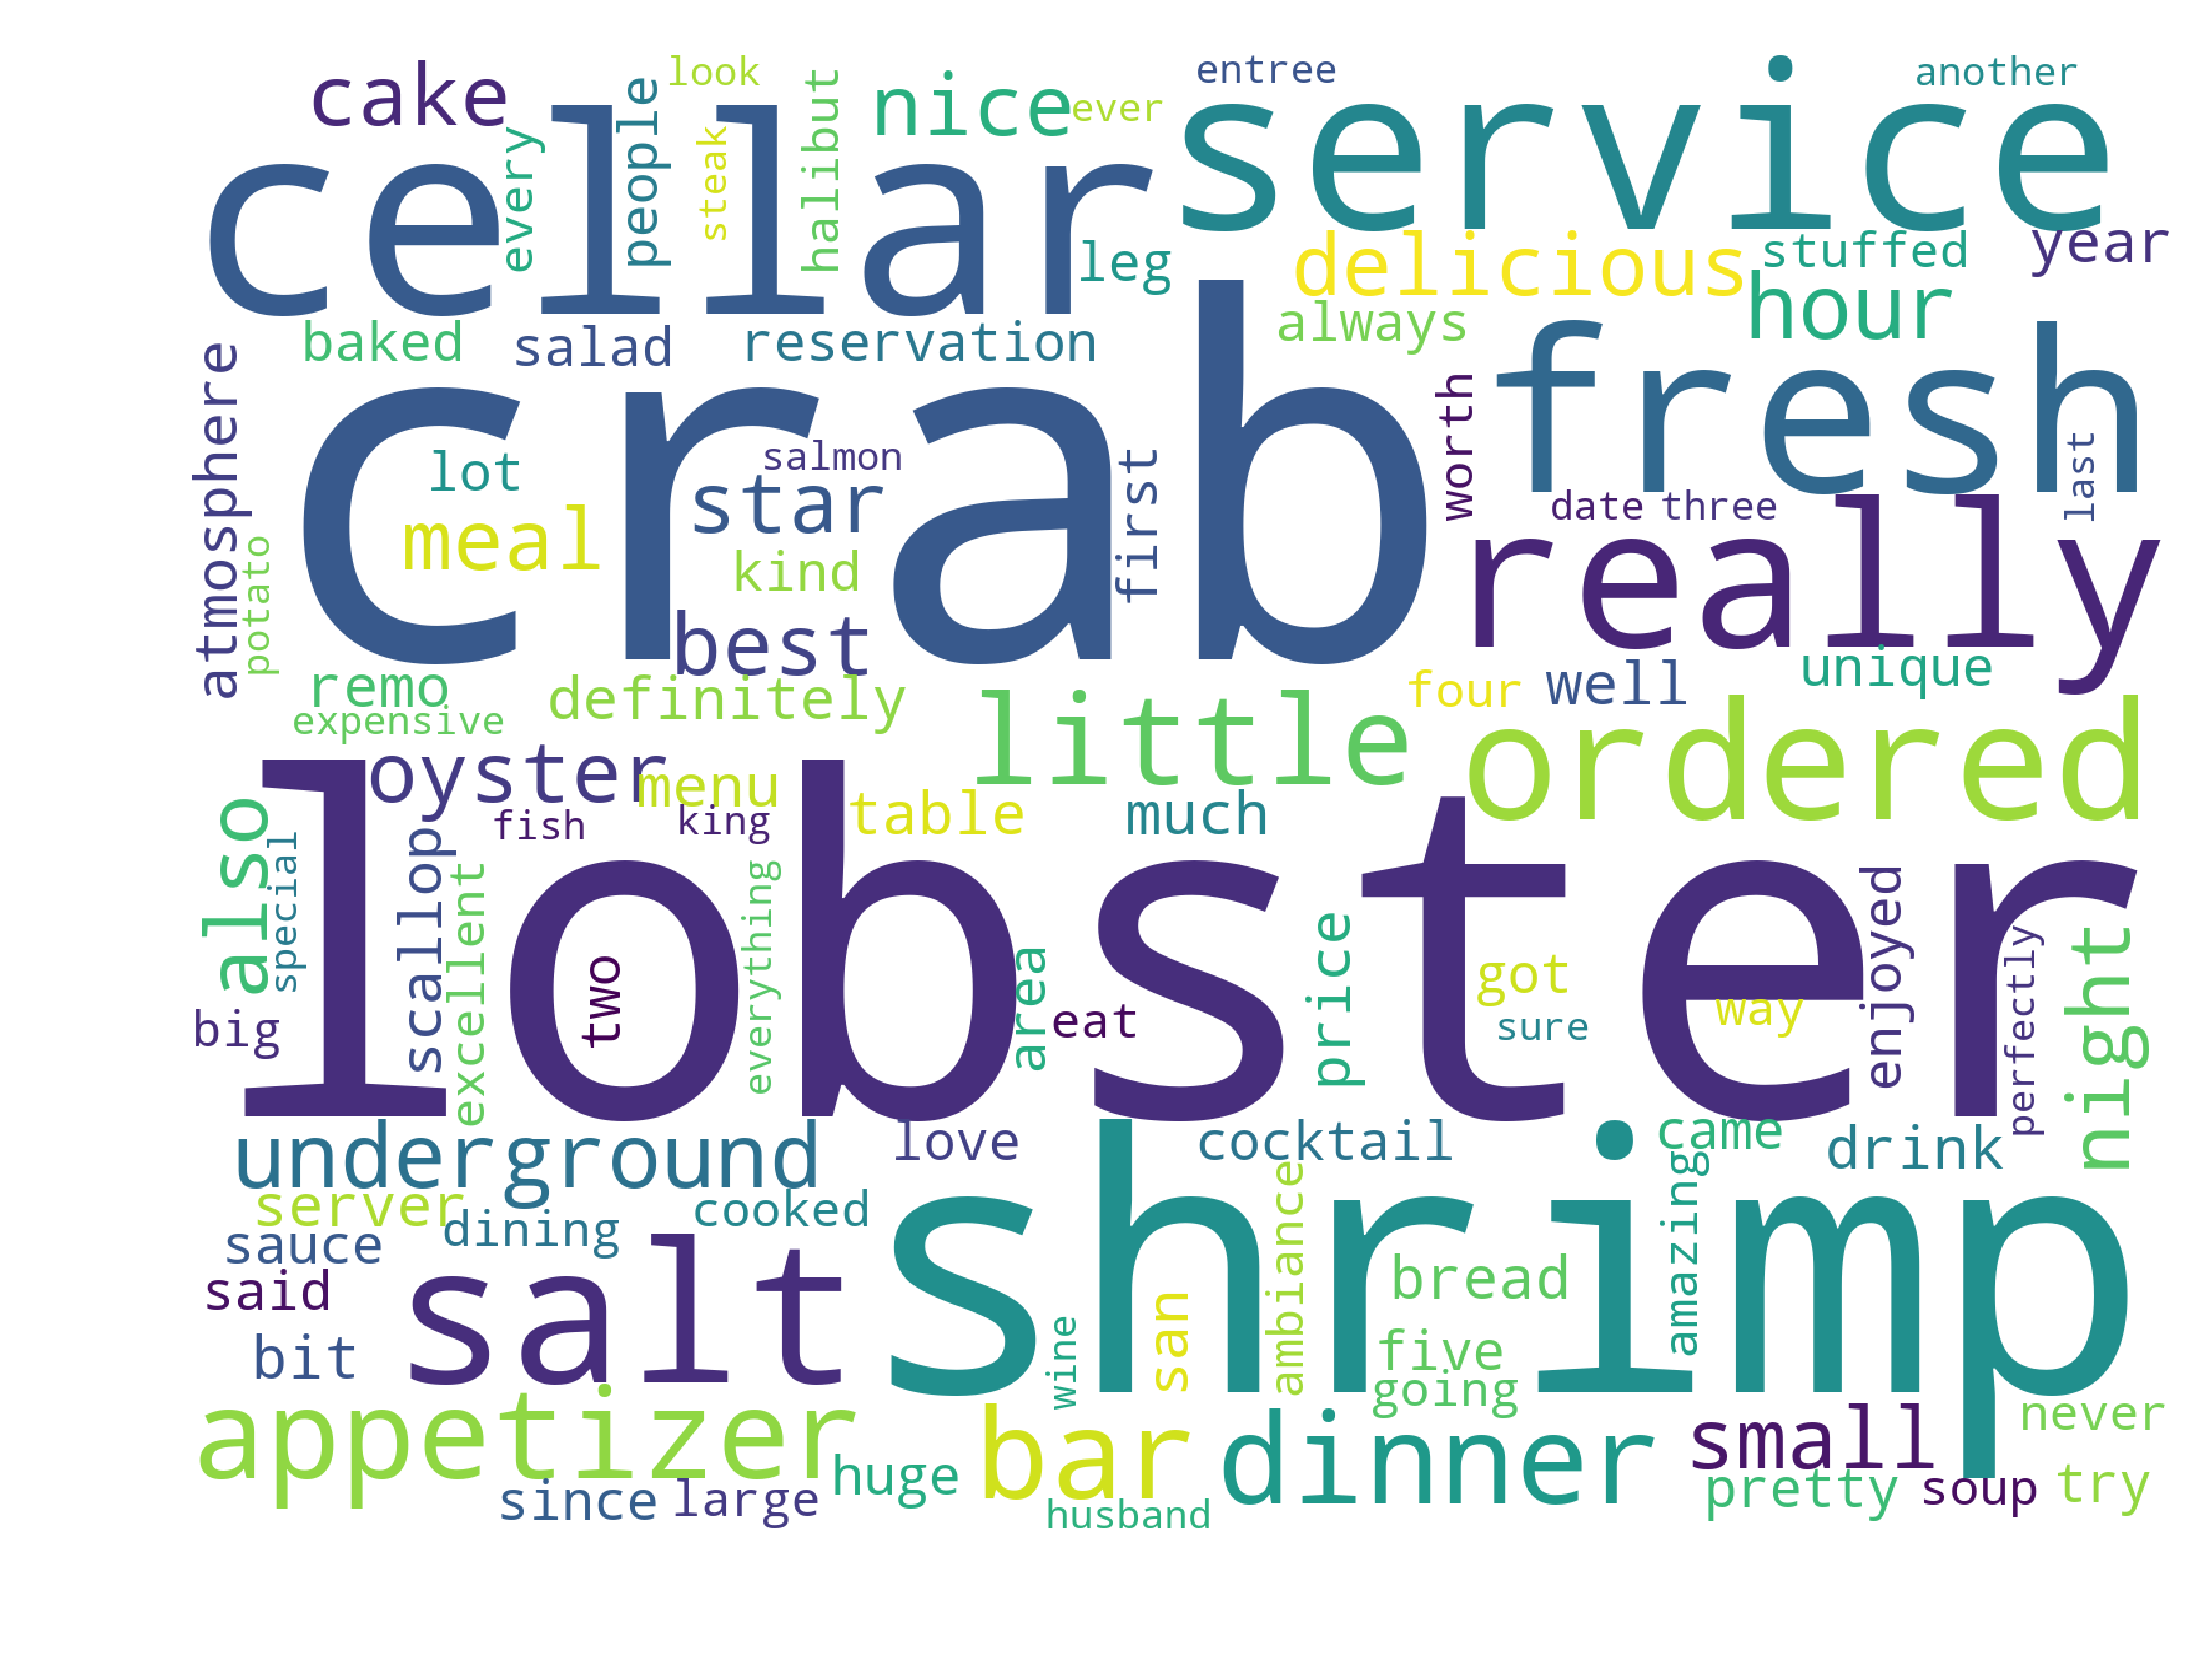

In [37]:
fourstarfreq = collections.Counter(fourstarwords)
for word in delete_words:
    fourstarfreq.pop(word)
common4 = dict(fourstarfreq.most_common(100))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color = 'White',width=400,height=300,scale=4,max_font_size=100)
wc.generate_from_frequencies(common4)

plt.figure(figsize=(10,6), dpi=600)
plt.imshow(wc)
plt.axis("off")
plt.savefig('wordcloud_fourstarwords.jpg')
plt.show()

## 100 most frequency wordcloud for 5 star restaurant

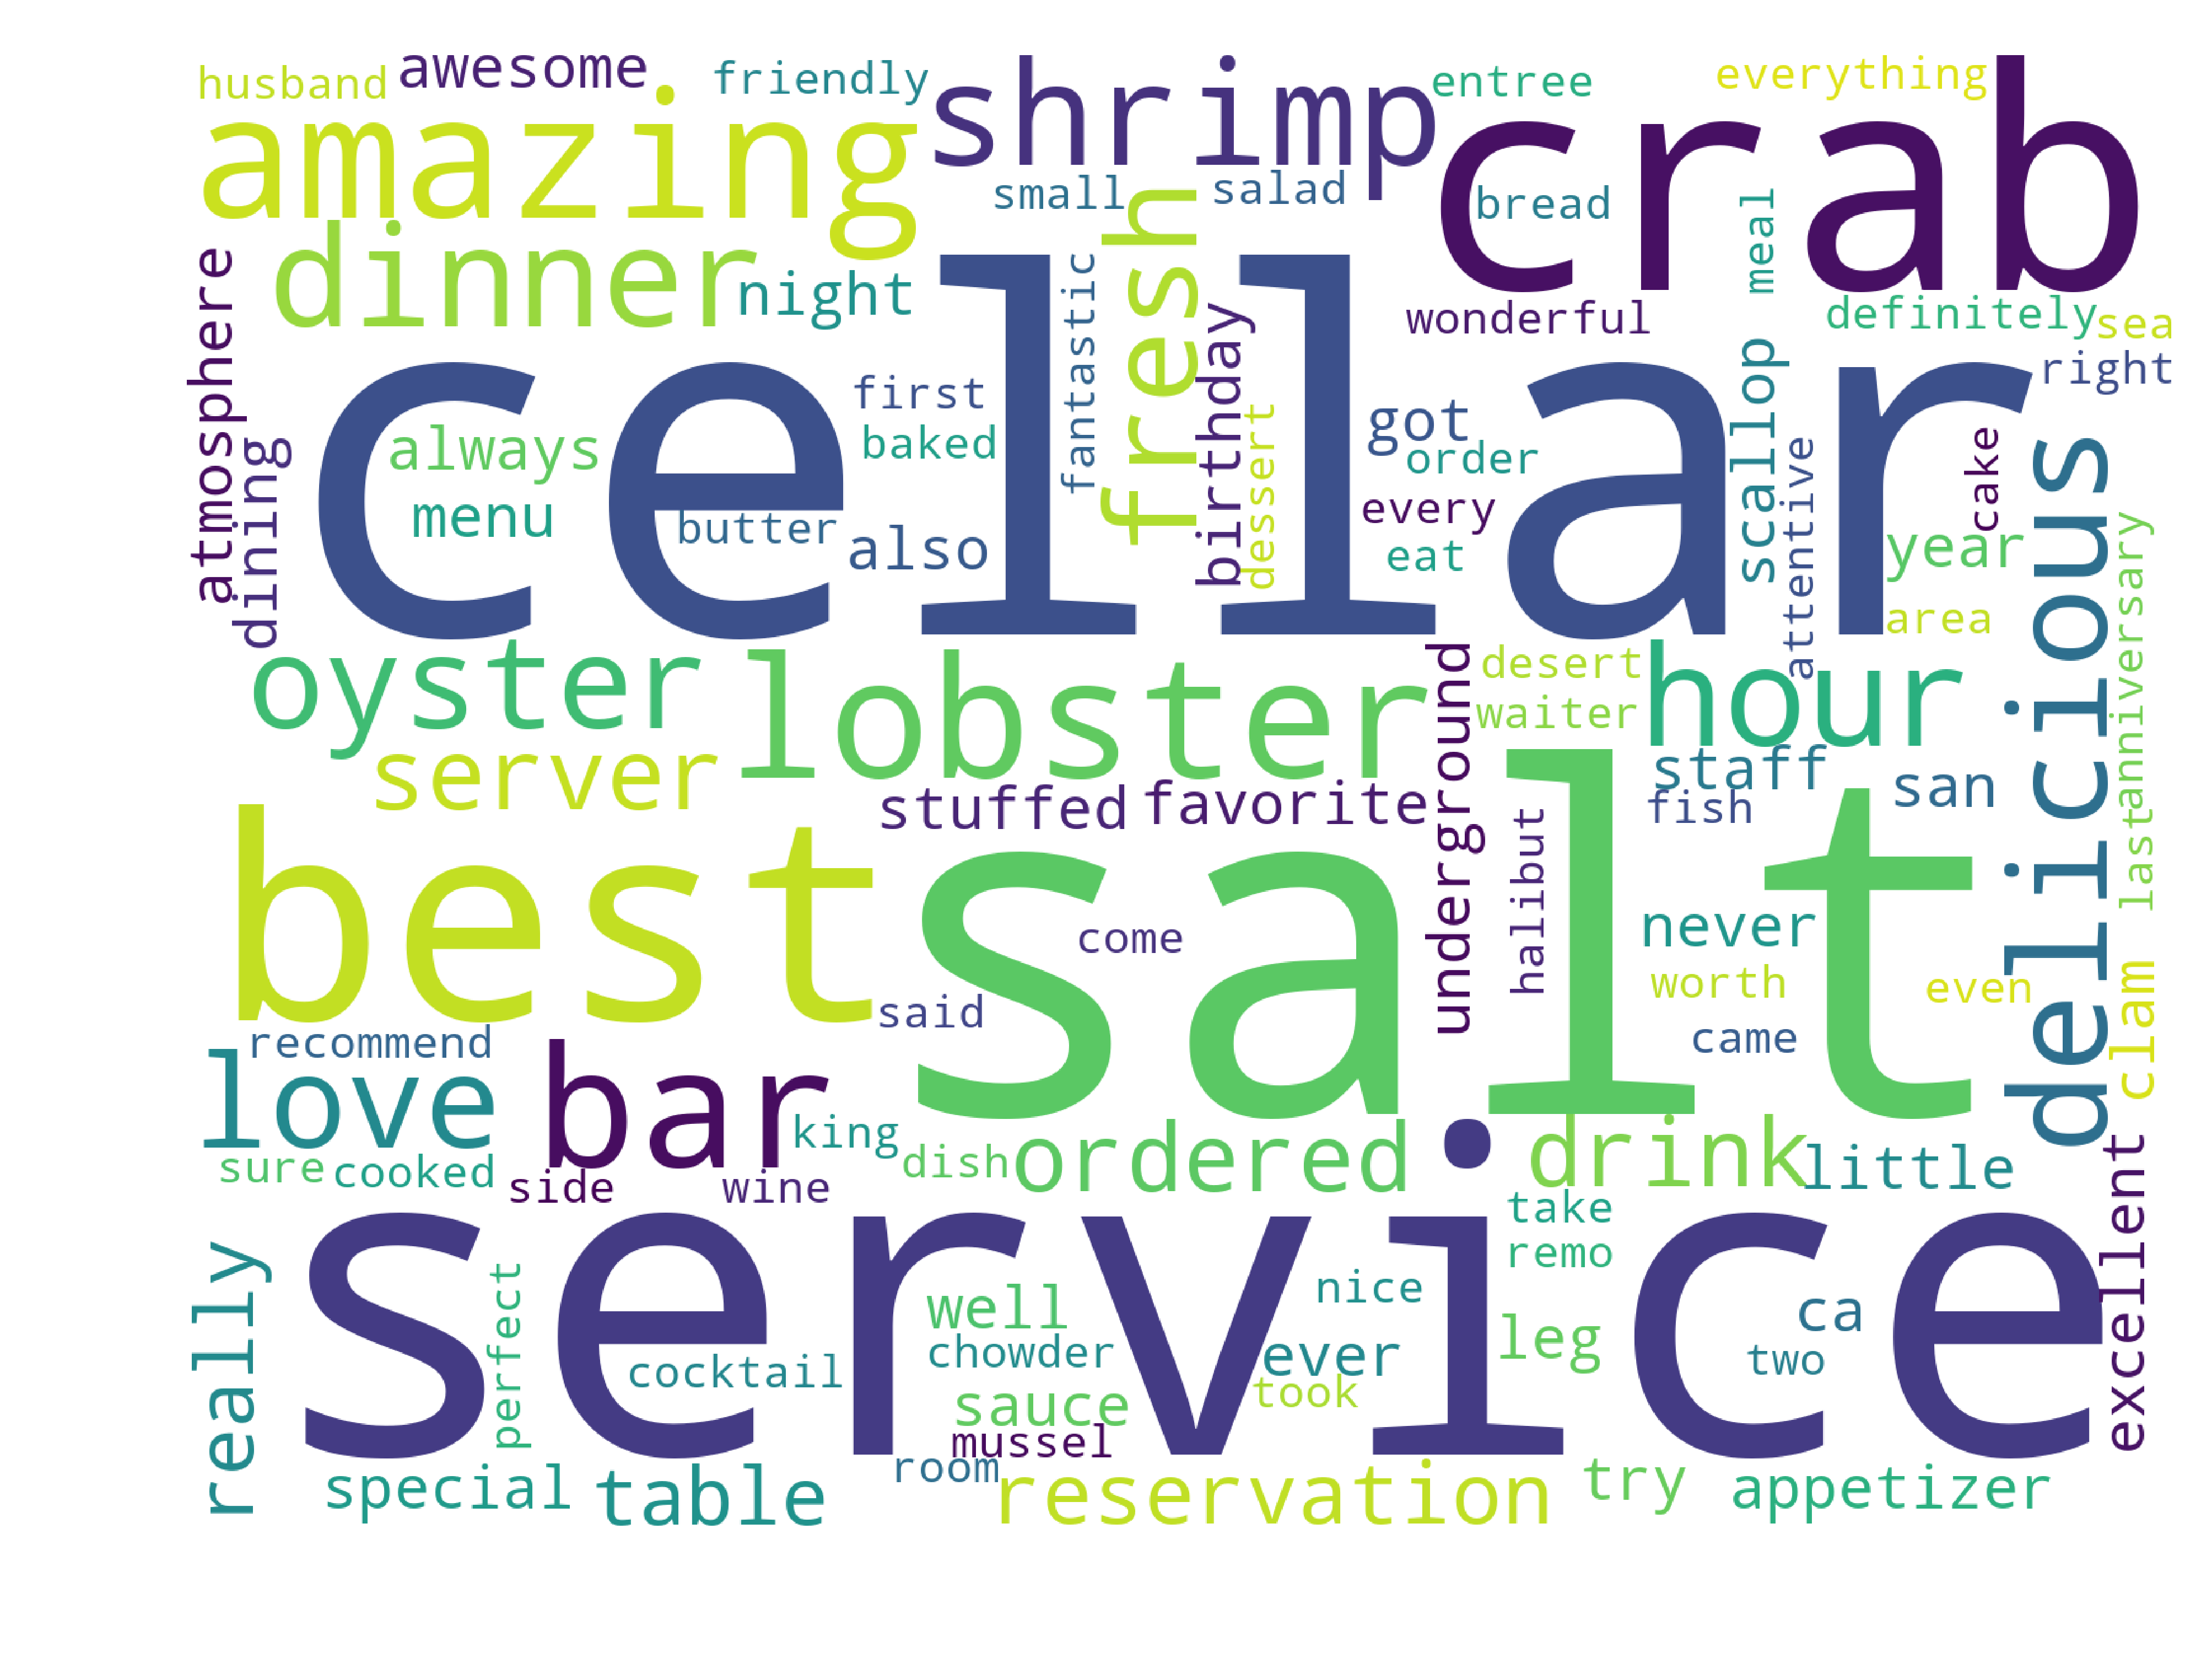

In [38]:
fivestarfreq = collections.Counter(fivestarwords)
for word in delete_words:
    fivestarfreq.pop(word)
common5 = dict(fivestarfreq.most_common(100))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color = 'White',width=400,height=300,scale=4,max_font_size=100)
wc.generate_from_frequencies(common5)

plt.figure(figsize=(10,6), dpi=600)
plt.imshow(wc)
plt.axis("off")
plt.savefig('wordcloud_fivestarwords.jpg')
plt.show()